# Machine Learning for the Stock Price Prediction

## Loading the preprocessed data

In [1]:
import pandas as pd 
import numpy as np

df = pd.read_csv('../data/pre-processed-data.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Stock Trading,Day,Month,Year
0,2012-01-04,14050,14050,13700,13720,559100,7719804000,4,1,2012
1,2012-01-05,13720,13840,13600,13800,511500,7030811000,5,1,2012
2,2012-01-06,13990,14030,13790,13850,765500,10635609000,6,1,2012
3,2012-01-10,13890,14390,13860,14390,952300,13533413000,10,1,2012
4,2012-01-11,14360,14750,14280,14590,1043400,15191988000,11,1,2012


## ARIMA Model

In [2]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt




In [3]:
# Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]



In [4]:
# Train ARIMA Model
model = ARIMA(train['Close'], order=(5, 1, 0))
model_fit = model.fit()



In [5]:
# Make Predictions
predictions = model_fit.forecast(steps=len(test))
test.loc[:,'Predictions'] = predictions



C:\Users\USER\AppData\Local\Temp\ipykernel_16668\1944980886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'Predictions'] = predictions


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate Model
mse = mean_squared_error(test['Close'], predictions)
mae = mean_absolute_error(test['Close'], predictions)
print(f'MSE: {mse}, MAE: {mae}')

MSE: 81139535.58771932, MAE: 7954.139395123441


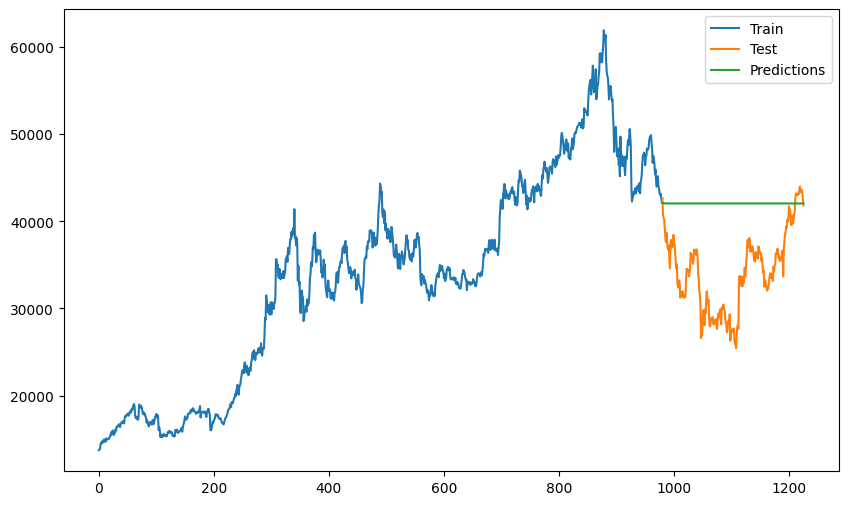

In [7]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(test['Predictions'], label='Predictions')
plt.legend()
plt.show()

## LSTM Model

In [8]:
df.set_index('Date', inplace=True)

In [9]:
df.index = pd.to_datetime(df.index)

In [10]:
# data preprocessing for LSTM
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])




In [11]:
# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)



In [12]:
# Train-Test Split
train_size = int(X.shape[0] * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input




In [14]:
# Build LSTM Model
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, 1))) 
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')



In [15]:
# Train Model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)



Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0884
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0037
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0016
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0016
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0017
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0016
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0016
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0015
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0013
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0013
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0012
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0012
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0012
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0012
Epoc

In [16]:

# Evaluate Model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f'MSE: {mse}, MAE: {mae}')


MSE: 1205899674.459648, MAE: 34463.62281399704


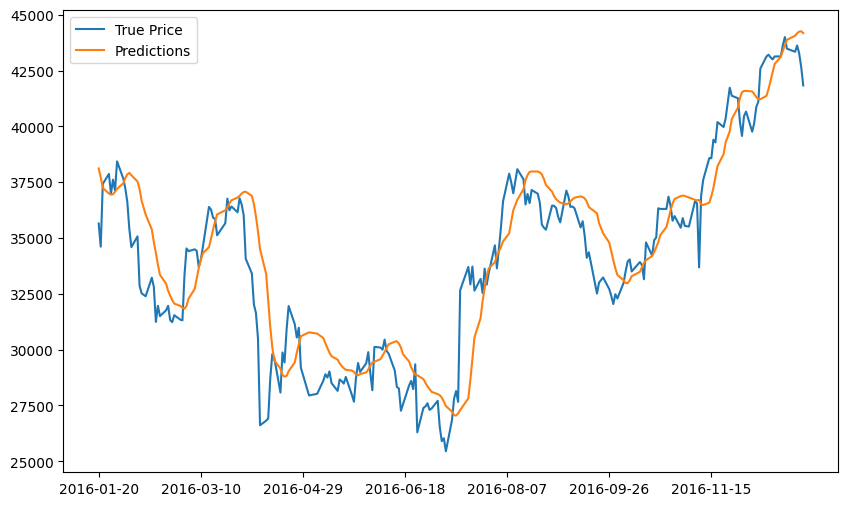

In [17]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size + SEQ_LENGTH:], df['Close'][train_size + SEQ_LENGTH:], label='True Price')
plt.plot(df.index[train_size + SEQ_LENGTH:], predictions, label='Predictions')
start_date = df.index[train_size + SEQ_LENGTH:][0]
end_date = df.index[train_size + SEQ_LENGTH:][-1]
date_range = pd.date_range(start=start_date, end=end_date, freq='50D')
formatted_dates = date_range.strftime('%Y-%m-%d')
plt.xticks(date_range, formatted_dates)
plt.legend()
plt.show()

## XGBoost

In [18]:
#feature engineering 

df['Lag1'] = df['Close'].shift(1)
df['Lag2'] = df['Close'].shift(2)
df['RollingMean'] = df['Close'].rolling(window=5).mean()

# Drop NaN values
df.dropna(inplace=True)

In [19]:
df.head()

,Open,High,Low,Close,Volume,Stock Trading,Day,Month,Year,Lag1,Lag2,RollingMean
Date,,,,,,,,,,,,
2012-01-11,14360,14750,14280,14590,1043400,15191988000,11,1,2012,14390.0,13850.0,14070.0
2012-01-12,14520,14600,14330,14520,540500,7814121000,12,1,2012,14590.0,14390.0,14230.0
2012-01-13,14740,14780,14450,14770,1543700,22669096000,13,1,2012,14520.0,14590.0,14424.0
2012-01-16,14610,14670,14530,14610,360100,5255652000,16,1,2012,14770.0,14520.0,14576.0
2012-01-17,14640,14820,14630,14750,442100,6511265000,17,1,2012,14610.0,14770.0,14648.0


In [20]:
import xgboost as xgb




In [21]:
# Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Define features and target
X_train, y_train = train.drop(columns=['Close']), train['Close']
X_test, y_test = test.drop(columns=['Close']), test['Close']



In [22]:
# Train XGBoost Model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Make Predictions
predictions = model.predict(X_test)



In [23]:
# Evaluate Model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f'MSE: {mse}, MAE: {mae}')



MSE: 276558.48932079395, MAE: 365.59194036989794


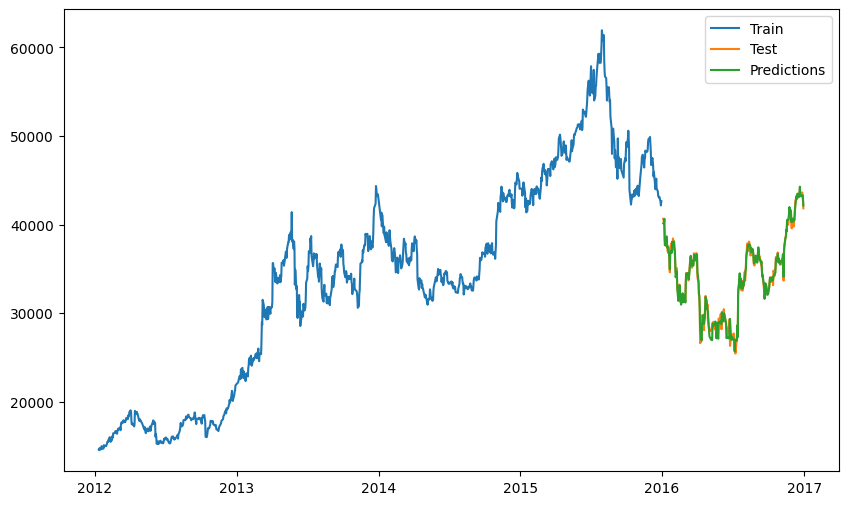

In [24]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, predictions, label='Predictions')
plt.legend()
plt.show()